In [1]:
using Revise, UnboundedBNN, Plots, ProgressMeter, Optimisers, Zygote, StatsFuns, LinearAlgebra

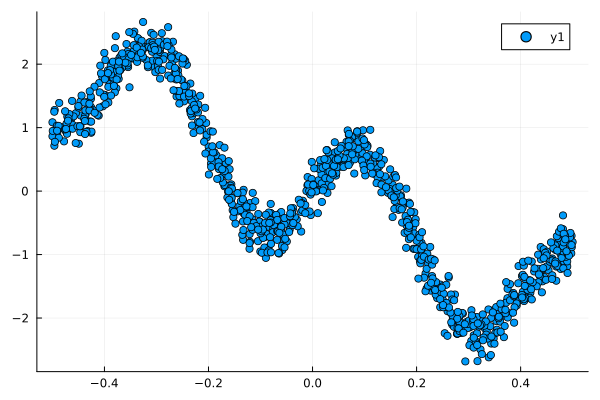

In [2]:
T = Float32
N = 1000
data_x = rand(T, N) .- 0.5f0
data_y = sin.(5*pi*data_x) .- 4 * data_x .+ 0.2f0 * randn(T, N)
# data_y = 1.5f0 * data_x.^3 - 0.2f0 * data_x + 0.005f0 * randn(T, N);
plot(data_x, data_y, seriestype = :scatter)

In [3]:
function loss(y, x, m; batch_prop = 1)
    @assert 0 < batch_prop <= 1

    # calculate KL divergence between posterior and prior of distribution over number of layers
    kl_poisson = KL_loss(m.posterior, m.prior)

    # calculate KL divergence between posterior and prior of distribution over weights of input layer
    kl_expansion = KL_loss(m.input_layer)
    
    # weighted KL over hidden and output layers
    mq = UnboundedBNN.support(m.posterior)
    kl_hidden_layers = KL_loss.(m.hidden_layers)
    kl_output_layers = KL_loss.(m.output_layers)
    ql = UnboundedBNN.pdf.(Ref(m.posterior), mq)
    # kl_layers = mapreduce(l -> ql[l] * (sum(kl_hidden_layers[1:l]) + kl_output_layers[l]), +, 1:mq[end])

    kl_total = 0 # kl_poisson + kl_expansion + kl_layers
    
    # calculate expected log likelihood
    # out = m.(x, 0)
    # println(length(out[1]))
    loglikelihoods = map(zip(x,y)) do (xi, yi)
        out = m(xi, 0)
        o_mean = vcat(first.(out)...)
        o_var = vcat(last.(out)...)
        logln = normlogpdf.(o_mean, sqrt.(o_var), yi)
        return dot(logln, ql)
    end
    # println(length(ql), length(loglikelihoods))
    # expected_logl = dot(ql, loglikelihood)
    expected_logl = sum(loglikelihoods)

    return -expected_logl + batch_prop * kl_total
end

loss (generic function with 1 method)

In [4]:
function predict(x, m)
    mq = UnboundedBNN.support(m.posterior)
    ql = UnboundedBNN.pdf.(Ref(m.posterior), mq)
    out = map(x) do xi
        o = m(xi, 0)
        o_mean = vcat(first.(o)...)
        o_var = vcat(last.(o)...)
        # THIS IS MOST LIKELY WRONG
        return dot(o_mean, ql), dot(o_var, ql)
    end
    return first.(out), last.(out)
end

predict (generic function with 1 method)

In [5]:
dimin = 1
dimmid = 10
dimout = 1

max_layers = 20

expansion_layer = Linear(dimin => dimmid)
intermediate_layer = ntuple(_ -> Skip(Chain(Linear(dimmid => dimmid), ReLU(), Linear(dimmid => dimmid))), max_layers)
output_layer = ntuple(_ -> Linear(dimmid => dimout), max_layers)
prior = Poisson(1)
posterior = TruncatedPoisson([invsoftplus(1f0)])
model = Unbounded(expansion_layer, intermediate_layer, output_layer, prior, posterior)

opt = Optimisers.setup(Adam(), model)
Optimisers.adjust!(opt.posterior, 1e-4)

In [6]:
model(0,1)

((Float32[31.128242;;], Float32[16133.266;;]), (Float32[358.08548;;], Float32[3.102056f6;;]), (Float32[-9694.216;;], Float32[9.1470426f8;;]), (Float32[35149.207;;], Float32[2.6725866f11;;]), (Float32[3.2353068f6;;], Float32[6.4082896f13;;]), (Float32[3.5467812f7;;], Float32[7.9757763f15;;]), (Float32[2.189298f8;;], Float32[2.4726804f18;;]), (Float32[-4.4391834f9;;], Float32[6.450823f20;;]))

In [7]:
loss(data_y[1:10], data_x[1:10], model)

70.45554306109028

In [8]:
model.posterior

TruncatedPoisson{1, 8, Vector{Float32}}(Float32[0.54132485])

In [14]:
epochs = 500
batch_size = 16
l_mem = zeros(epochs)
gs = nothing
@showprogress for e in 1:epochs
    for n in Iterators.partition(1:N, batch_size)
        _, gs = Zygote.withgradient(m -> loss(data_y[n], data_x[n], m; batch_prop = length(n)/N), model)
        opt, model = Optimisers.update!(opt, model, gs[1])
    end
    l_mem[e] = loss(data_y, data_x, model)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:41


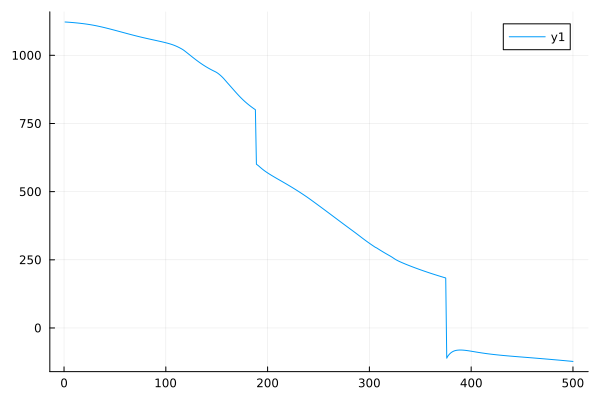

In [15]:
plot(l_mem)

In [16]:
model.posterior

TruncatedPoisson{3, 10, Vector{Float32}}(Float32[2.771854])

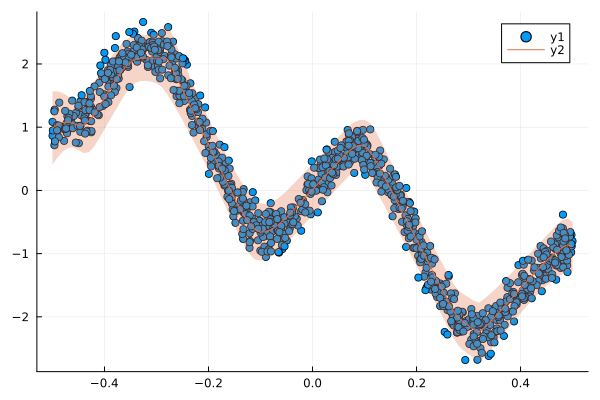

In [17]:
x_test = -0.5:0.01:0.5
y_test_mean, y_test_var = predict(x_test, model)
plot(data_x, data_y, seriestype = :scatter)
plot!(x_test, y_test_mean, ribbon = 2*sqrt.(y_test_var), fillalpha = 0.3)

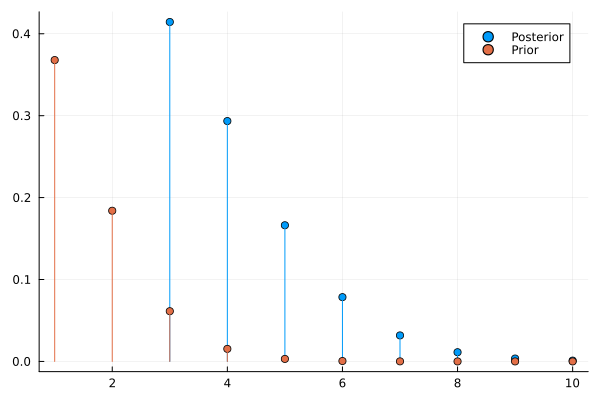

In [18]:
plot(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.posterior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Posterior")
plot!(1:UnboundedBNN.max_support(model.posterior), UnboundedBNN.pdf.(Ref(model.prior), 1:UnboundedBNN.max_support(model.posterior)), line=:stem, marker=:circle, label="Prior")

In [19]:
UnboundedBNN.support(model.posterior)

3:10

In [25]:
UnboundedBNN.pdf.(Ref(Poisson(softplus(model.posterior.λ[1]))), 1:10)

10-element Vector{Float32}:
 0.16673419
 0.2361391
 0.2229564
 0.15788223
 0.08944097
 0.042223923
 0.01708574
 0.0060494663
 0.0019039164
 0.00053928845